# Utilizzo della libreria Backtester

Questo notebook mostra come utilizzare la libreria di backtesting che abbiamo creato per testare strategie di trading con le Bollinger Bands.

## 1. Importazione delle librerie

In [1]:
# Importa i moduli della libreria backtester
import sys
sys.path.append('/home/edocame/Desktop/bollingerBands')  # Aggiungi il path

from modules.backtester import data_loader, indicators, backtest_engine, visualization, utils
import pandas as pd
import numpy as np

# Importa anche matplotlib per i grafici
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Caricamento e preparazione dei dati

In [2]:
# Carica i dati tick dal file Parquet
file_path = '/home/edocame/Desktop/data_python/03_BID_ASK_DATA/EURCHF_oanda_alltime.parquet'
tick_data = data_loader.load_parquet_data(file_path)

print(f"Dati caricati: {len(tick_data)} righe")
print(f"Periodo: {tick_data.index.min()} - {tick_data.index.max()}")
print(f"Colonne: {tick_data.columns.tolist()}")
print("\nPrime righe:")
print(tick_data.head())

Dati caricati: 378784726 righe
Periodo: 0 - 378784725
Colonne: ['datetime', 'bid', 'ask']

Prime righe:
                 datetime      bid      ask
0 2003-08-04 03:00:03.491  1.53844  1.53854
1 2003-08-04 03:00:36.109  1.53820  1.53845
2 2003-08-04 03:00:36.301  1.53834  1.53859
3 2003-08-04 03:00:46.305  1.53822  1.53832
4 2003-08-04 03:00:46.497  1.53838  1.53848


In [3]:
# Assicurati che la colonna 'datetime' sia di tipo datetime e impostala come indice
if not pd.api.types.is_datetime64_any_dtype(tick_data['datetime']):
    tick_data['datetime'] = pd.to_datetime(tick_data['datetime'], errors='coerce')
    print('Colonna datetime convertita in datetime.')
else:
    print('Colonna datetime già in formato datetime.')

# Imposta la colonna 'datetime' come indice
if tick_data.index.name != 'datetime':
    tick_data = tick_data.set_index('datetime')
    print('Colonna datetime impostata come indice.')
else:
    print('Colonna datetime già impostata come indice.')

# Mostra le prime righe per conferma
print(tick_data.head())

Colonna datetime già in formato datetime.
Colonna datetime impostata come indice.
                             bid      ask
datetime                                 
2003-08-04 03:00:03.491  1.53844  1.53854
2003-08-04 03:00:36.109  1.53820  1.53845
2003-08-04 03:00:36.301  1.53834  1.53859
2003-08-04 03:00:46.305  1.53822  1.53832
2003-08-04 03:00:46.497  1.53838  1.53848


In [4]:
# Prepara i dati a minuto
minute_data = data_loader.prepare_minute_data(tick_data, resample_rule='1T')

print(f"Dati a minuto: {len(minute_data)} righe")
print(f"Periodo: {minute_data.index.min()} - {minute_data.index.max()}")
print("\nPrime righe:")
print(minute_data.head())

/home/edocame/Desktop/bollingerBands/modules/backtester/data_loader.py:96: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  minute_sample = tick_data.resample(resample_rule).agg({'bid': 'first', 'ask': 'first'})


Dati a minuto: 8182527 righe
Periodo: 2003-08-04 03:00:00 - 2025-07-11 23:59:00

Prime righe:
                         bid      ask  midprice
datetime                                       
2003-08-04 03:00:00  1.53844  1.53854   1.53849
2003-08-04 03:01:00  1.53803  1.53823   1.53813
2003-08-04 03:02:00  1.53777  1.53801   1.53789
2003-08-04 03:03:00  1.53772  1.53796   1.53784
2003-08-04 03:04:00  1.53764  1.53774   1.53769


## 3. Calcolo degli indicatori tecnici

In [ ]:
# Calcola le Bollinger Bands
window = 1440  # 24 ore = 1440 minuti
num_std_dev = 1.0

data_with_bands = indicators.bollinger_bands(
    minute_data, 
    price_column='midprice',
    window=window, 
    num_std_dev=num_std_dev
)

# Rimuovi le righe con valori NaN
complete_data = data_with_bands.dropna()

print(f"Dati completi per il backtest: {len(complete_data)} righe")
print(f"Colonne disponibili: {complete_data.columns.tolist()}")
print("\nPrime righe con indicatori:")
print(complete_data.head())

## 4. Esecuzione del backtest

In [ ]:
# Crea e esegui il backtest
backtester = backtest_engine.Backtest(complete_data)
results_data = backtester.run()

# Stampa il riassunto delle performance
backtester.print_performance_summary()

## 5. Analisi dei risultati

In [ ]:
# Ottieni i risultati come DataFrame
trades_df = backtester.get_trades_dataframe()

if not trades_df.empty:
    print(f"Numero di trade: {len(trades_df)}")
    print("\nPrimi 10 trade:")
    print(trades_df.head(10))
    
    # Statistiche aggiuntive
    win_loss_stats = utils.calculate_win_loss_ratio(trades_df['PnL'])
    print("\nStatistiche Win/Loss:")
    for key, value in win_loss_stats.items():
        print(f"  {key}: {value:.2f}")
else:
    print("Nessun trade eseguito.")

## 6. Visualizzazione dei risultati

In [ ]:
# Visualizza i prezzi con le Bollinger Bands
# Prendi un subset dei dati per una visualizzazione più chiara
subset_data = complete_data.iloc[-2000:]  # Ultimi 2000 punti

visualization.plot_price_with_bollinger_bands(
    subset_data, 
    title="EURCHF con Bollinger Bands (ultimi 2000 punti)"
)

In [ ]:
# Visualizza il PnL cumulativo
if not trades_df.empty:
    visualization.plot_cumulative_pnl(
        trades_df, 
        title="PnL Cumulativo - Strategia Bollinger Bands"
    )

In [ ]:
# Visualizza la distribuzione dei trade
if not trades_df.empty:
    visualization.plot_trade_distribution(
        trades_df, 
        title="Distribuzione PnL dei Trade"
    )

## 7. Grafici interattivi (Plotly)

In [ ]:
# Grafico interattivo dei prezzi con Bollinger Bands
visualization.plot_interactive_price_bands(
    subset_data, 
    title="EURCHF con Bollinger Bands - Grafico Interattivo"
)

In [ ]:
# Grafico interattivo del PnL cumulativo
if not trades_df.empty:
    visualization.plot_interactive_cumulative_pnl(
        trades_df, 
        title="PnL Cumulativo - Grafico Interattivo"
    )

## 8. Confronto con dati reali (se disponibili)

In [ ]:
# Carica i dati di balance reali per confronto
try:
    balance_file = '/home/edocame/Desktop/bollingerBands/DATA/eurchf_1440_01.csv'
    balance_data = data_loader.load_balance_data(balance_file)
    
    print(f"Dati balance caricati: {len(balance_data)} righe")
    print(f"Periodo balance: {balance_data.index.min()} - {balance_data.index.max()}")
    
    # Confronta con i risultati del backtest
    if not trades_df.empty:
        # Trova il periodo comune tra backtest e balance
        # Assumiamo che trades_df abbia una colonna 'Exit_Time' con i timestamp
        if 'Exit_Time' in trades_df.columns:
            backtest_start = trades_df['Exit_Time'].min()
            backtest_end = trades_df['Exit_Time'].max()
        else:
            # Se non c'è Exit_Time, usa l'indice del DataFrame completo
            backtest_start = complete_data.index.min()
            backtest_end = complete_data.index.max()
        
        balance_start = balance_data.index.min()
        balance_end = balance_data.index.max()
        
        # Calcola il periodo comune
        common_start = max(backtest_start, balance_start)
        common_end = min(backtest_end, balance_end)
        
        print(f"\nPeriodo backtest: {backtest_start} - {backtest_end}")
        print(f"Periodo balance: {balance_start} - {balance_end}")
        print(f"Periodo comune: {common_start} - {common_end}")
        
        # Verifica che esista un periodo comune
        if common_start <= common_end:
            # Filtra i dati al periodo comune
            if 'Exit_Time' in trades_df.columns:
                trades_common = trades_df[
                    (trades_df['Exit_Time'] >= common_start) & 
                    (trades_df['Exit_Time'] <= common_end)
                ]
            else:
                # Se non c'è Exit_Time, crea un dataset filtrato basato sui timestamp
                trades_common = trades_df.copy()
                
            balance_common = balance_data.loc[common_start:common_end]
            
            print(f"\nTrade nel periodo comune: {len(trades_common)}")
            print(f"Righe balance nel periodo comune: {len(balance_common)}")
            
            # Crea il grafico di confronto solo per il periodo comune
            if len(trades_common) > 0 and len(balance_common) > 0:
                visualization.compare_backtest_vs_real_balance(
                    trades_common, 
                    balance_common, 
                    title=f"Confronto: Backtest vs Balance Reale ({common_start.strftime('%Y-%m-%d')} - {common_end.strftime('%Y-%m-%d')})"
                )
                
                # Mostra anche alcune statistiche di confronto
                print(f"\n=== STATISTICHE PERIODO COMUNE ===")
                print(f"PnL finale backtest: {trades_common['Cumulative_PnL'].iloc[-1]:.2f} pips")
                print(f"Balance finale reale: {balance_common['<BALANCE>'].iloc[-1]:.2f}")
                
                # Calcola la correlazione se possibile
                if len(trades_common) > 1 and len(balance_common) > 1:
                    # Resample per allineare le frequenze
                    try:
                        balance_daily = balance_common['<BALANCE>'].resample('D').last().dropna()
                        trades_daily = trades_common.set_index('Exit_Time')['Cumulative_PnL'].resample('D').last().dropna()
                        
                        # Trova l'intersezione delle date
                        common_dates = balance_daily.index.intersection(trades_daily.index)
                        
                        if len(common_dates) > 2:
                            corr = balance_daily.loc[common_dates].corr(trades_daily.loc[common_dates])
                            print(f"Correlazione giornaliera: {corr:.3f}")
                        else:
                            print("Insufficienti dati per calcolare la correlazione")
                    except Exception as e:
                        print(f"Errore nel calcolo della correlazione: {e}")
            else:
                print("ERRORE: Nessun dato disponibile nel periodo comune filtrato")
        else:
            print("ERRORE: Non ci sono date in comune tra backtest e balance!")
    else:
        print("Nessun trade disponibile per il confronto")
        
except Exception as e:
    print(f"Errore nel caricamento dei dati balance: {e}")

## 9. Dashboard completo

In [ ]:
# Crea un dashboard completo con tutti i grafici
if not trades_df.empty:
    visualization.create_performance_dashboard(
        subset_data, 
        trades_df, 
        backtester.performance_metrics
    )

## 10. Test con parametri diversi

In [ ]:
# Forza il reload del modulo per assicurarsi che le nuove funzioni siano disponibili
import importlib
import sys

# Reload del modulo backtest_engine per caricare le nuove funzioni
if 'backtester.backtest_engine' in sys.modules:
    importlib.reload(sys.modules['backtester.backtest_engine'])

# Importa le funzioni di ottimizzazione dal backtest_engine
from modules.backtester.backtest_engine import optimize_parameters, plot_top_equity_curves

# Esegui l'ottimizzazione dei parametri con multiprocessing
print("Avvio ottimizzazione parametri...")
parameter_results = optimize_parameters(
    minute_data=minute_data,
    window_start=60,
    window_stop=14400,
    window_step=60,
    std_start=0.2,
    std_stop=4.0,
    std_step=0.2,
    price_column='midprice'
)

# Mostra i risultati completi
print("\n=== TUTTI I RISULTATI ===")
print(parameter_results.to_string(index=False))

# Plotta le top 5 equity curves usando la funzione dedicata
print("\nGenerazione grafici delle migliori equity curves...")
plot_top_equity_curves(
    results_df=parameter_results,
    minute_data=minute_data,
    top_n=5,
    price_column='midprice'
)

## Walk forward opt

In [5]:
# Crea un subset di minute_data in base a start_date e end_date
start_date = '2023-01-01'
end_date = '2025-07-05'
subset_df = minute_data.loc[start_date:end_date]

print(f"Subset creato: {len(subset_df)} righe")
print(f"Periodo: {subset_df.index.min()} - {subset_df.index.max()}")
print(subset_df.head())

Subset creato: 929880 righe
Periodo: 2023-01-02 00:42:00 - 2025-07-04 23:58:00
                         bid      ask  midprice
datetime                                       
2023-01-02 00:42:00  0.98520  0.98688  0.986040
2023-01-02 01:15:00  0.98607  0.98889  0.987480
2023-01-02 01:16:00  0.98610  0.98891  0.987505
2023-01-02 01:17:00  0.98609  0.98890  0.987495
2023-01-02 01:18:00  0.98610  0.98891  0.987505


Starting Walk Forward Optimization...
=== WALK FORWARD OPTIMIZATION ===
Lookback period: 180 days (259200 minutes)
Optimization interval: 5 days
Total data period: 2023-01-02 00:42:00 to 2025-07-04 23:58:00

--- Period 1 ---
Optimization: 2023-01-02 00:42:00 to 2023-09-12 16:09:00
Trading: 2023-09-12 16:10:00 to 2023-09-19 18:01:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 38.83it/s]


Optimal parameters: window=8400, std_dev=0.5
Insufficient trading data for period 1, skipping...

--- Period 2 ---
Optimization: 2023-01-09 03:54:00 to 2023-09-19 18:01:00
Trading: 2023-09-19 18:02:00 to 2023-09-26 19:57:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 46.22it/s]


Optimal parameters: window=5400, std_dev=2.0
Period 2 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 3 ---
Optimization: 2023-01-16 05:11:00 to 2023-09-26 19:57:00
Trading: 2023-09-26 19:58:00 to 2023-10-03 21:00:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 47.62it/s]


Optimal parameters: window=2400, std_dev=2.5
Period 3 results: PnL=40.90 pips, Trades=4, Win Rate=75.0%

--- Period 4 ---
Optimization: 2023-01-23 05:56:00 to 2023-10-03 21:00:00
Trading: 2023-10-03 21:01:00 to 2023-10-10 21:55:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 47.39it/s]


Optimal parameters: window=2400, std_dev=2.5
Period 4 results: PnL=-13.90 pips, Trades=1, Win Rate=0.0%

--- Period 5 ---
Optimization: 2023-01-30 06:54:00 to 2023-10-10 21:55:00
Trading: 2023-10-10 21:56:00 to 2023-10-17 23:21:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 45.12it/s]


Optimal parameters: window=2400, std_dev=2.5
Period 5 results: PnL=-24.10 pips, Trades=3, Win Rate=66.7%

--- Period 6 ---
Optimization: 2023-02-06 07:39:00 to 2023-10-17 23:21:00
Trading: 2023-10-17 23:23:00 to 2023-10-25 00:29:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 42.06it/s]


Optimal parameters: window=3400, std_dev=2.0
Period 6 results: PnL=38.70 pips, Trades=2, Win Rate=100.0%

--- Period 7 ---
Optimization: 2023-02-13 08:17:00 to 2023-10-25 00:29:00
Trading: 2023-10-25 00:30:00 to 2023-11-01 01:38:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 41.47it/s]



Optimal parameters: window=5400, std_dev=2.0
Period 7 results: PnL=-58.30 pips, Trades=1, Win Rate=0.0%

--- Period 8 ---
Optimization: 2023-02-20 08:58:00 to 2023-11-01 01:38:00
Trading: 2023-11-01 01:39:00 to 2023-11-08 02:58:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 39.32it/s]


Optimal parameters: window=5400, std_dev=2.0
Period 8 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 9 ---
Optimization: 2023-02-27 09:52:00 to 2023-11-08 02:58:00
Trading: 2023-11-08 02:59:00 to 2023-11-15 04:45:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 40.66it/s]


Optimal parameters: window=5400, std_dev=2.0
Period 9 results: PnL=-16.10 pips, Trades=1, Win Rate=0.0%

--- Period 10 ---
Optimization: 2023-03-06 10:44:00 to 2023-11-15 04:45:00
Trading: 2023-11-15 04:46:00 to 2023-11-22 05:49:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 45.33it/s]


Optimal parameters: window=5400, std_dev=1.0
Period 10 results: PnL=13.90 pips, Trades=2, Win Rate=50.0%

--- Period 11 ---
Optimization: 2023-03-13 12:03:00 to 2023-11-22 05:49:00
Trading: 2023-11-22 05:50:00 to 2023-11-29 07:58:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 40.76it/s]



Optimal parameters: window=5400, std_dev=1.0
Period 11 results: PnL=18.20 pips, Trades=3, Win Rate=100.0%

--- Period 12 ---
Optimization: 2023-03-20 13:05:00 to 2023-11-29 07:58:00
Trading: 2023-11-29 07:59:00 to 2023-12-06 08:49:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 39.92it/s]



Optimal parameters: window=5400, std_dev=1.0
Period 12 results: PnL=-15.30 pips, Trades=1, Win Rate=0.0%

--- Period 13 ---
Optimization: 2023-03-27 13:42:00 to 2023-12-06 08:49:00
Trading: 2023-12-06 08:50:00 to 2023-12-13 09:47:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 41.80it/s]


Optimal parameters: window=5400, std_dev=1.0
Period 13 results: PnL=21.10 pips, Trades=1, Win Rate=100.0%

--- Period 14 ---
Optimization: 2023-04-03 14:11:00 to 2023-12-13 09:47:00
Trading: 2023-12-13 09:48:00 to 2023-12-20 10:22:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 44.28it/s]


Optimal parameters: window=5400, std_dev=1.0
Period 14 results: PnL=-1.80 pips, Trades=2, Win Rate=50.0%

--- Period 15 ---
Optimization: 2023-04-10 15:10:00 to 2023-12-20 10:22:00
Trading: 2023-12-20 10:23:00 to 2023-12-28 11:31:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 45.64it/s]


Optimal parameters: window=5400, std_dev=1.0
Period 15 results: PnL=-41.30 pips, Trades=6, Win Rate=83.3%

--- Period 16 ---
Optimization: 2023-04-17 15:45:00 to 2023-12-28 11:31:00
Trading: 2023-12-28 11:32:00 to 2024-01-05 12:37:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 46.07it/s]


Optimal parameters: window=5400, std_dev=1.0
Period 16 results: PnL=42.60 pips, Trades=2, Win Rate=100.0%

--- Period 17 ---
Optimization: 2023-04-24 16:24:00 to 2024-01-05 12:37:00
Trading: 2024-01-05 12:38:00 to 2024-01-12 13:34:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 46.18it/s]


Optimal parameters: window=5400, std_dev=1.0
Period 17 results: PnL=-22.80 pips, Trades=1, Win Rate=0.0%

--- Period 18 ---
Optimization: 2023-05-01 17:18:00 to 2024-01-12 13:34:00
Trading: 2024-01-12 13:35:00 to 2024-01-19 15:23:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 42.74it/s]


Optimal parameters: window=4400, std_dev=1.0
Period 18 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 19 ---
Optimization: 2023-05-08 17:56:00 to 2024-01-19 15:23:00
Trading: 2024-01-19 15:24:00 to 2024-01-26 16:29:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 43.19it/s]


Optimal parameters: window=5400, std_dev=1.0
Period 19 results: PnL=-51.90 pips, Trades=1, Win Rate=0.0%

--- Period 20 ---
Optimization: 2023-05-15 18:35:00 to 2024-01-26 16:29:00
Trading: 2024-01-26 16:30:00 to 2024-02-02 17:17:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 42.15it/s]


Optimal parameters: window=5400, std_dev=1.0
Period 20 results: PnL=7.90 pips, Trades=1, Win Rate=100.0%

--- Period 21 ---
Optimization: 2023-05-22 19:24:00 to 2024-02-02 17:17:00
Trading: 2024-02-02 17:18:00 to 2024-02-09 18:26:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 43.72it/s]


Optimal parameters: window=3400, std_dev=1.0
Period 21 results: PnL=-76.10 pips, Trades=1, Win Rate=0.0%

--- Period 22 ---
Optimization: 2023-05-29 20:37:00 to 2024-02-09 18:26:00
Trading: 2024-02-09 18:27:00 to 2024-02-16 19:31:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 43.24it/s]


Optimal parameters: window=5400, std_dev=1.0
Period 22 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 23 ---
Optimization: 2023-06-05 21:35:00 to 2024-02-16 19:31:00
Trading: 2024-02-16 19:32:00 to 2024-02-23 21:16:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 45.31it/s]


Optimal parameters: window=3400, std_dev=1.0
Period 23 results: PnL=23.60 pips, Trades=4, Win Rate=75.0%

--- Period 24 ---
Optimization: 2023-06-12 22:26:00 to 2024-02-23 21:16:00
Trading: 2024-02-23 21:17:00 to 2024-03-01 21:53:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 46.17it/s]


Optimal parameters: window=1400, std_dev=2.5
Period 24 results: PnL=-20.90 pips, Trades=4, Win Rate=50.0%

--- Period 25 ---
Optimization: 2023-06-19 23:32:00 to 2024-03-01 21:53:00
Trading: 2024-03-01 21:54:00 to 2024-03-08 22:23:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 46.90it/s]


Optimal parameters: window=5400, std_dev=1.0
Period 25 results: PnL=2.60 pips, Trades=1, Win Rate=100.0%

--- Period 26 ---
Optimization: 2023-06-27 00:40:00 to 2024-03-08 22:23:00
Trading: 2024-03-08 22:24:00 to 2024-03-15 23:19:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 47.11it/s]


Optimal parameters: window=2400, std_dev=1.5
Period 26 results: PnL=-7.30 pips, Trades=4, Win Rate=75.0%

--- Period 27 ---
Optimization: 2023-07-04 02:01:00 to 2024-03-15 23:19:00
Trading: 2024-03-15 23:20:00 to 2024-03-25 00:11:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 42.18it/s]


Optimal parameters: window=1400, std_dev=2.5
Period 27 results: PnL=-6.20 pips, Trades=3, Win Rate=66.7%

--- Period 28 ---
Optimization: 2023-07-11 03:20:00 to 2024-03-25 00:11:00
Trading: 2024-03-25 00:12:00 to 2024-04-01 01:27:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 47.00it/s]


Optimal parameters: window=4400, std_dev=5.5
Period 28 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 29 ---
Optimization: 2023-07-18 05:03:00 to 2024-04-01 01:27:00
Trading: 2024-04-01 01:28:00 to 2024-04-08 02:17:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 46.25it/s]


Optimal parameters: window=4400, std_dev=5.5
Period 29 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 30 ---
Optimization: 2023-07-25 06:15:00 to 2024-04-08 02:17:00
Trading: 2024-04-08 02:18:00 to 2024-04-15 03:08:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 44.17it/s]


Optimal parameters: window=4400, std_dev=5.5
Period 30 results: PnL=-30.10 pips, Trades=1, Win Rate=0.0%

--- Period 31 ---
Optimization: 2023-08-01 07:38:00 to 2024-04-15 03:08:00
Trading: 2024-04-15 03:09:00 to 2024-04-22 03:57:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 46.17it/s]


Optimal parameters: window=4400, std_dev=5.5
Period 31 results: PnL=56.80 pips, Trades=1, Win Rate=100.0%

--- Period 32 ---
Optimization: 2023-08-08 08:44:00 to 2024-04-22 03:57:00
Trading: 2024-04-22 03:58:00 to 2024-04-29 05:05:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 45.32it/s]


Optimal parameters: window=7400, std_dev=5.5
Insufficient trading data for period 32, skipping...

--- Period 33 ---
Optimization: 2023-08-15 10:25:00 to 2024-04-29 05:05:00
Trading: 2024-04-29 05:06:00 to 2024-05-06 05:50:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 45.64it/s]


Optimal parameters: window=7400, std_dev=5.5
Insufficient trading data for period 33, skipping...

--- Period 34 ---
Optimization: 2023-08-22 11:30:00 to 2024-05-06 05:50:00
Trading: 2024-05-06 05:51:00 to 2024-05-13 07:25:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 46.02it/s]


Optimal parameters: window=7400, std_dev=5.5
Insufficient trading data for period 34, skipping...

--- Period 35 ---
Optimization: 2023-08-29 13:00:00 to 2024-05-13 07:25:00
Trading: 2024-05-13 07:26:00 to 2024-05-20 08:58:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 46.31it/s]


Optimal parameters: window=7400, std_dev=5.5
Insufficient trading data for period 35, skipping...

--- Period 36 ---
Optimization: 2023-09-05 14:45:00 to 2024-05-20 08:58:00
Trading: 2024-05-20 08:59:00 to 2024-05-27 10:34:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 46.16it/s]


Optimal parameters: window=7400, std_dev=5.5
Insufficient trading data for period 36, skipping...

--- Period 37 ---
Optimization: 2023-09-12 16:10:00 to 2024-05-27 10:34:00
Trading: 2024-05-27 10:35:00 to 2024-06-03 12:07:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 44.09it/s]


Optimal parameters: window=7400, std_dev=5.5
Insufficient trading data for period 37, skipping...

--- Period 38 ---
Optimization: 2023-09-19 18:02:00 to 2024-06-03 12:07:00
Trading: 2024-06-03 12:08:00 to 2024-06-10 13:04:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 44.79it/s]


Optimal parameters: window=7400, std_dev=5.5
Insufficient trading data for period 38, skipping...

--- Period 39 ---
Optimization: 2023-09-26 19:58:00 to 2024-06-10 13:04:00
Trading: 2024-06-10 13:05:00 to 2024-06-17 14:57:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 44.49it/s]


Optimal parameters: window=4400, std_dev=5.5
Period 39 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 40 ---
Optimization: 2023-10-03 21:01:00 to 2024-06-17 14:57:00
Trading: 2024-06-17 14:58:00 to 2024-06-24 17:08:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 46.45it/s]


Optimal parameters: window=5400, std_dev=6.0
Period 40 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 41 ---
Optimization: 2023-10-10 21:56:00 to 2024-06-24 17:08:00
Trading: 2024-06-24 17:09:00 to 2024-07-01 18:28:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 45.96it/s]


Optimal parameters: window=5400, std_dev=6.0
Period 41 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 42 ---
Optimization: 2023-10-17 23:23:00 to 2024-07-01 18:28:00
Trading: 2024-07-01 18:29:00 to 2024-07-08 21:18:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 44.60it/s]


Optimal parameters: window=5400, std_dev=6.0
Period 42 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 43 ---
Optimization: 2023-10-25 00:30:00 to 2024-07-08 21:18:00
Trading: 2024-07-08 21:19:00 to 2024-07-15 23:09:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 42.59it/s]



Optimal parameters: window=5400, std_dev=6.0
Period 43 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 44 ---
Optimization: 2023-11-01 01:39:00 to 2024-07-15 23:09:00
Trading: 2024-07-15 23:10:00 to 2024-07-23 00:28:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 45.43it/s]


Optimal parameters: window=5400, std_dev=6.0
Period 44 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 45 ---
Optimization: 2023-11-08 02:59:00 to 2024-07-23 00:28:00
Trading: 2024-07-23 00:29:00 to 2024-07-30 01:22:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 43.72it/s]


Optimal parameters: window=5400, std_dev=6.0
Period 45 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 46 ---
Optimization: 2023-11-15 04:46:00 to 2024-07-30 01:22:00
Trading: 2024-07-30 01:23:00 to 2024-08-06 02:19:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 46.85it/s]


Optimal parameters: window=5400, std_dev=6.0
Period 46 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 47 ---
Optimization: 2023-11-22 05:50:00 to 2024-08-06 02:19:00
Trading: 2024-08-06 02:20:00 to 2024-08-13 03:02:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 46.64it/s]


Optimal parameters: window=5400, std_dev=6.0
Period 47 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 48 ---
Optimization: 2023-11-29 07:59:00 to 2024-08-13 03:02:00
Trading: 2024-08-13 03:03:00 to 2024-08-20 03:37:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 46.74it/s]


Optimal parameters: window=5400, std_dev=6.0
Period 48 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 49 ---
Optimization: 2023-12-06 08:50:00 to 2024-08-20 03:37:00
Trading: 2024-08-20 03:38:00 to 2024-08-27 04:14:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 44.23it/s]


Optimal parameters: window=5400, std_dev=6.0
Period 49 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 50 ---
Optimization: 2023-12-13 09:48:00 to 2024-08-27 04:14:00
Trading: 2024-08-27 04:15:00 to 2024-09-03 05:34:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 43.57it/s]


Optimal parameters: window=5400, std_dev=6.0
Period 50 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 51 ---
Optimization: 2023-12-20 10:23:00 to 2024-09-03 05:34:00
Trading: 2024-09-03 05:35:00 to 2024-09-10 06:18:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 43.20it/s]


Optimal parameters: window=7400, std_dev=5.5
Insufficient trading data for period 51, skipping...

--- Period 52 ---
Optimization: 2023-12-28 11:32:00 to 2024-09-10 06:18:00
Trading: 2024-09-10 06:19:00 to 2024-09-17 07:02:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 43.06it/s]


Optimal parameters: window=5400, std_dev=6.0
Period 52 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 53 ---
Optimization: 2024-01-05 12:38:00 to 2024-09-17 07:02:00
Trading: 2024-09-17 07:03:00 to 2024-09-24 07:28:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 43.43it/s]


Optimal parameters: window=5400, std_dev=6.0
Period 53 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 54 ---
Optimization: 2024-01-12 13:35:00 to 2024-09-24 07:28:00
Trading: 2024-09-24 07:29:00 to 2024-10-01 07:57:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 42.59it/s]


Optimal parameters: window=5400, std_dev=6.0
Period 54 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 55 ---
Optimization: 2024-01-19 15:24:00 to 2024-10-01 07:57:00
Trading: 2024-10-01 07:58:00 to 2024-10-08 08:27:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 45.85it/s]


Optimal parameters: window=5400, std_dev=6.0
Period 55 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 56 ---
Optimization: 2024-01-26 16:30:00 to 2024-10-08 08:27:00
Trading: 2024-10-08 08:28:00 to 2024-10-15 10:08:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 46.05it/s]


Optimal parameters: window=5400, std_dev=6.0
Period 56 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 57 ---
Optimization: 2024-02-02 17:18:00 to 2024-10-15 10:08:00
Trading: 2024-10-15 10:09:00 to 2024-10-22 10:52:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 43.96it/s]


Optimal parameters: window=5400, std_dev=6.0
Period 57 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 58 ---
Optimization: 2024-02-09 18:27:00 to 2024-10-22 10:52:00
Trading: 2024-10-22 10:53:00 to 2024-10-29 11:33:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 45.39it/s]


Optimal parameters: window=5400, std_dev=6.0
Period 58 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 59 ---
Optimization: 2024-02-16 19:32:00 to 2024-10-29 11:33:00
Trading: 2024-10-29 11:34:00 to 2024-11-05 12:22:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 44.54it/s]


Optimal parameters: window=5400, std_dev=6.0
Period 59 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 60 ---
Optimization: 2024-02-23 21:17:00 to 2024-11-05 12:22:00
Trading: 2024-11-05 12:23:00 to 2024-11-12 12:54:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 46.23it/s]


Optimal parameters: window=5400, std_dev=6.0
Period 60 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 61 ---
Optimization: 2024-03-01 21:54:00 to 2024-11-12 12:54:00
Trading: 2024-11-12 12:55:00 to 2024-11-19 13:44:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 45.48it/s]


Optimal parameters: window=5400, std_dev=6.0
Period 61 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 62 ---
Optimization: 2024-03-08 22:24:00 to 2024-11-19 13:44:00
Trading: 2024-11-19 13:45:00 to 2024-11-26 14:09:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 44.48it/s]


Optimal parameters: window=5400, std_dev=6.0
Period 62 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 63 ---
Optimization: 2024-03-15 23:20:00 to 2024-11-26 14:09:00
Trading: 2024-11-26 14:10:00 to 2024-12-03 14:43:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 44.89it/s]


Optimal parameters: window=2400, std_dev=6.0
Period 63 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 64 ---
Optimization: 2024-03-25 00:12:00 to 2024-12-03 14:43:00
Trading: 2024-12-03 14:44:00 to 2024-12-10 15:26:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 45.07it/s]


Optimal parameters: window=7400, std_dev=5.5
Insufficient trading data for period 64, skipping...

--- Period 65 ---
Optimization: 2024-04-01 01:28:00 to 2024-12-10 15:26:00
Trading: 2024-12-10 15:27:00 to 2024-12-17 16:00:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 45.32it/s]


Optimal parameters: window=7400, std_dev=5.5
Insufficient trading data for period 65, skipping...

--- Period 66 ---
Optimization: 2024-04-08 02:18:00 to 2024-12-17 16:00:00
Trading: 2024-12-17 16:01:00 to 2024-12-24 16:39:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 44.56it/s]


Optimal parameters: window=7400, std_dev=5.5
Insufficient trading data for period 66, skipping...

--- Period 67 ---
Optimization: 2024-04-15 03:09:00 to 2024-12-24 16:39:00
Trading: 2024-12-24 16:40:00 to 2025-01-02 14:21:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 44.12it/s]



Optimal parameters: window=2400, std_dev=6.0
Period 67 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 68 ---
Optimization: 2024-04-22 03:58:00 to 2025-01-02 14:21:00
Trading: 2025-01-02 14:22:00 to 2025-01-09 14:46:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 44.79it/s]


Optimal parameters: window=2400, std_dev=6.0
Period 68 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 69 ---
Optimization: 2024-04-29 05:06:00 to 2025-01-09 14:46:00
Trading: 2025-01-09 14:47:00 to 2025-01-16 15:09:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 44.89it/s]


Optimal parameters: window=2400, std_dev=6.0
Period 69 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 70 ---
Optimization: 2024-05-06 05:51:00 to 2025-01-16 15:09:00
Trading: 2025-01-16 15:10:00 to 2025-01-23 15:37:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 45.28it/s]


Optimal parameters: window=2400, std_dev=6.0
Period 70 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 71 ---
Optimization: 2024-05-13 07:26:00 to 2025-01-23 15:37:00
Trading: 2025-01-23 15:38:00 to 2025-01-30 16:00:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 46.23it/s]


Optimal parameters: window=2400, std_dev=6.0
Period 71 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 72 ---
Optimization: 2024-05-20 08:59:00 to 2025-01-30 16:00:00
Trading: 2025-01-30 16:01:00 to 2025-02-06 16:24:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 46.10it/s]


Optimal parameters: window=2400, std_dev=6.0
Period 72 results: PnL=0.00 pips, Trades=0, Win Rate=0.0%

--- Period 73 ---
Optimization: 2024-05-27 10:35:00 to 2025-02-06 16:24:00
Trading: 2025-02-06 16:25:00 to 2025-02-13 17:00:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 46.88it/s]


Optimal parameters: window=8400, std_dev=0.5
Insufficient trading data for period 73, skipping...

--- Period 74 ---
Optimization: 2024-06-03 12:08:00 to 2025-02-13 17:00:00
Trading: 2025-02-13 17:01:00 to 2025-02-20 17:29:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 45.61it/s]


Optimal parameters: window=7400, std_dev=0.5
Insufficient trading data for period 74, skipping...

--- Period 75 ---
Optimization: 2024-06-10 13:05:00 to 2025-02-20 17:29:00
Trading: 2025-02-20 17:30:00 to 2025-02-27 17:59:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 43.14it/s]



Optimal parameters: window=7400, std_dev=0.5
Insufficient trading data for period 75, skipping...

--- Period 76 ---
Optimization: 2024-06-17 14:58:00 to 2025-02-27 17:59:00
Trading: 2025-02-27 18:00:00 to 2025-03-06 18:26:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 43.91it/s]


Optimal parameters: window=7400, std_dev=0.5
Insufficient trading data for period 76, skipping...

--- Period 77 ---
Optimization: 2024-06-24 17:09:00 to 2025-03-06 18:26:00
Trading: 2025-03-06 18:27:00 to 2025-03-13 19:10:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 44.47it/s]


Optimal parameters: window=7400, std_dev=0.5
Insufficient trading data for period 77, skipping...

--- Period 78 ---
Optimization: 2024-07-01 18:29:00 to 2025-03-13 19:10:00
Trading: 2025-03-13 19:11:00 to 2025-03-20 19:57:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 45.07it/s]


Optimal parameters: window=7400, std_dev=0.5
Insufficient trading data for period 78, skipping...

--- Period 79 ---
Optimization: 2024-07-08 21:19:00 to 2025-03-20 19:57:00
Trading: 2025-03-20 19:58:00 to 2025-03-27 20:32:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 43.53it/s]


Optimal parameters: window=7400, std_dev=0.5
Insufficient trading data for period 79, skipping...

--- Period 80 ---
Optimization: 2024-07-15 23:10:00 to 2025-03-27 20:32:00
Trading: 2025-03-27 20:33:00 to 2025-04-03 21:07:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 44.55it/s]


Optimal parameters: window=4400, std_dev=2.5
Period 80 results: PnL=26.80 pips, Trades=2, Win Rate=50.0%

--- Period 81 ---
Optimization: 2024-07-23 00:29:00 to 2025-04-03 21:07:00
Trading: 2025-04-03 21:08:00 to 2025-04-10 21:55:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 45.40it/s]


Optimal parameters: window=8400, std_dev=0.5
Insufficient trading data for period 81, skipping...

--- Period 82 ---
Optimization: 2024-07-30 01:23:00 to 2025-04-10 21:55:00
Trading: 2025-04-10 21:56:00 to 2025-04-17 22:37:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 45.52it/s]


Optimal parameters: window=4400, std_dev=2.5
Period 82 results: PnL=10.20 pips, Trades=1, Win Rate=100.0%

--- Period 83 ---
Optimization: 2024-08-06 02:20:00 to 2025-04-17 22:37:00
Trading: 2025-04-17 22:38:00 to 2025-04-24 23:34:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 43.59it/s]



Optimal parameters: window=4400, std_dev=1.0
Period 83 results: PnL=-31.80 pips, Trades=1, Win Rate=0.0%

--- Period 84 ---
Optimization: 2024-08-13 03:03:00 to 2025-04-24 23:34:00
Trading: 2025-04-24 23:35:00 to 2025-05-02 00:20:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 44.03it/s]


Optimal parameters: window=4400, std_dev=1.0
Period 84 results: PnL=7.10 pips, Trades=2, Win Rate=50.0%

--- Period 85 ---
Optimization: 2024-08-20 03:38:00 to 2025-05-02 00:20:00
Trading: 2025-05-02 00:21:00 to 2025-05-09 01:27:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 45.36it/s]


Optimal parameters: window=4400, std_dev=1.0
Period 85 results: PnL=36.50 pips, Trades=2, Win Rate=100.0%

--- Period 86 ---
Optimization: 2024-08-27 04:15:00 to 2025-05-09 01:27:00
Trading: 2025-05-09 01:28:00 to 2025-05-16 01:58:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 45.06it/s]


Optimal parameters: window=4400, std_dev=1.0
Period 86 results: PnL=-24.40 pips, Trades=2, Win Rate=0.0%

--- Period 87 ---
Optimization: 2024-09-03 05:35:00 to 2025-05-16 01:58:00
Trading: 2025-05-16 01:59:00 to 2025-05-23 02:44:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 45.46it/s]


Optimal parameters: window=4400, std_dev=1.0
Period 87 results: PnL=31.40 pips, Trades=2, Win Rate=100.0%

--- Period 88 ---
Optimization: 2024-09-10 06:19:00 to 2025-05-23 02:44:00
Trading: 2025-05-23 02:45:00 to 2025-05-30 03:43:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 45.20it/s]


Optimal parameters: window=4400, std_dev=1.0
Period 88 results: PnL=68.70 pips, Trades=4, Win Rate=100.0%

--- Period 89 ---
Optimization: 2024-09-17 07:03:00 to 2025-05-30 03:43:00
Trading: 2025-05-30 03:44:00 to 2025-06-06 04:08:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 45.85it/s]


Optimal parameters: window=4400, std_dev=1.0
Period 89 results: PnL=3.20 pips, Trades=3, Win Rate=66.7%

--- Period 90 ---
Optimization: 2024-09-24 07:29:00 to 2025-06-06 04:08:00
Trading: 2025-06-06 04:09:00 to 2025-06-13 04:33:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 44.80it/s]


Optimal parameters: window=4400, std_dev=1.0
Period 90 results: PnL=-51.10 pips, Trades=3, Win Rate=33.3%

--- Period 91 ---
Optimization: 2024-10-01 07:58:00 to 2025-06-13 04:33:00
Trading: 2025-06-13 04:34:00 to 2025-06-20 05:02:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 44.61it/s]


Optimal parameters: window=3400, std_dev=1.5
Period 91 results: PnL=104.70 pips, Trades=5, Win Rate=100.0%

--- Period 92 ---
Optimization: 2024-10-08 08:28:00 to 2025-06-20 05:02:00
Trading: 2025-06-20 05:03:00 to 2025-06-27 05:28:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 45.18it/s]


Optimal parameters: window=3400, std_dev=1.5
Period 92 results: PnL=-9.30 pips, Trades=1, Win Rate=0.0%

--- Period 93 ---
Optimization: 2024-10-15 10:09:00 to 2025-06-27 05:28:00
Trading: 2025-06-27 05:29:00 to 2025-07-04 05:56:00
Starting optimization with 108 parameter combinations...
Using single-threaded approach for reliability.


Parameter optimization: 100%|██████████| 108/108 [00:02<00:00, 45.82it/s]



Optimal parameters: window=3400, std_dev=1.5
Period 93 results: PnL=25.80 pips, Trades=3, Win Rate=66.7%


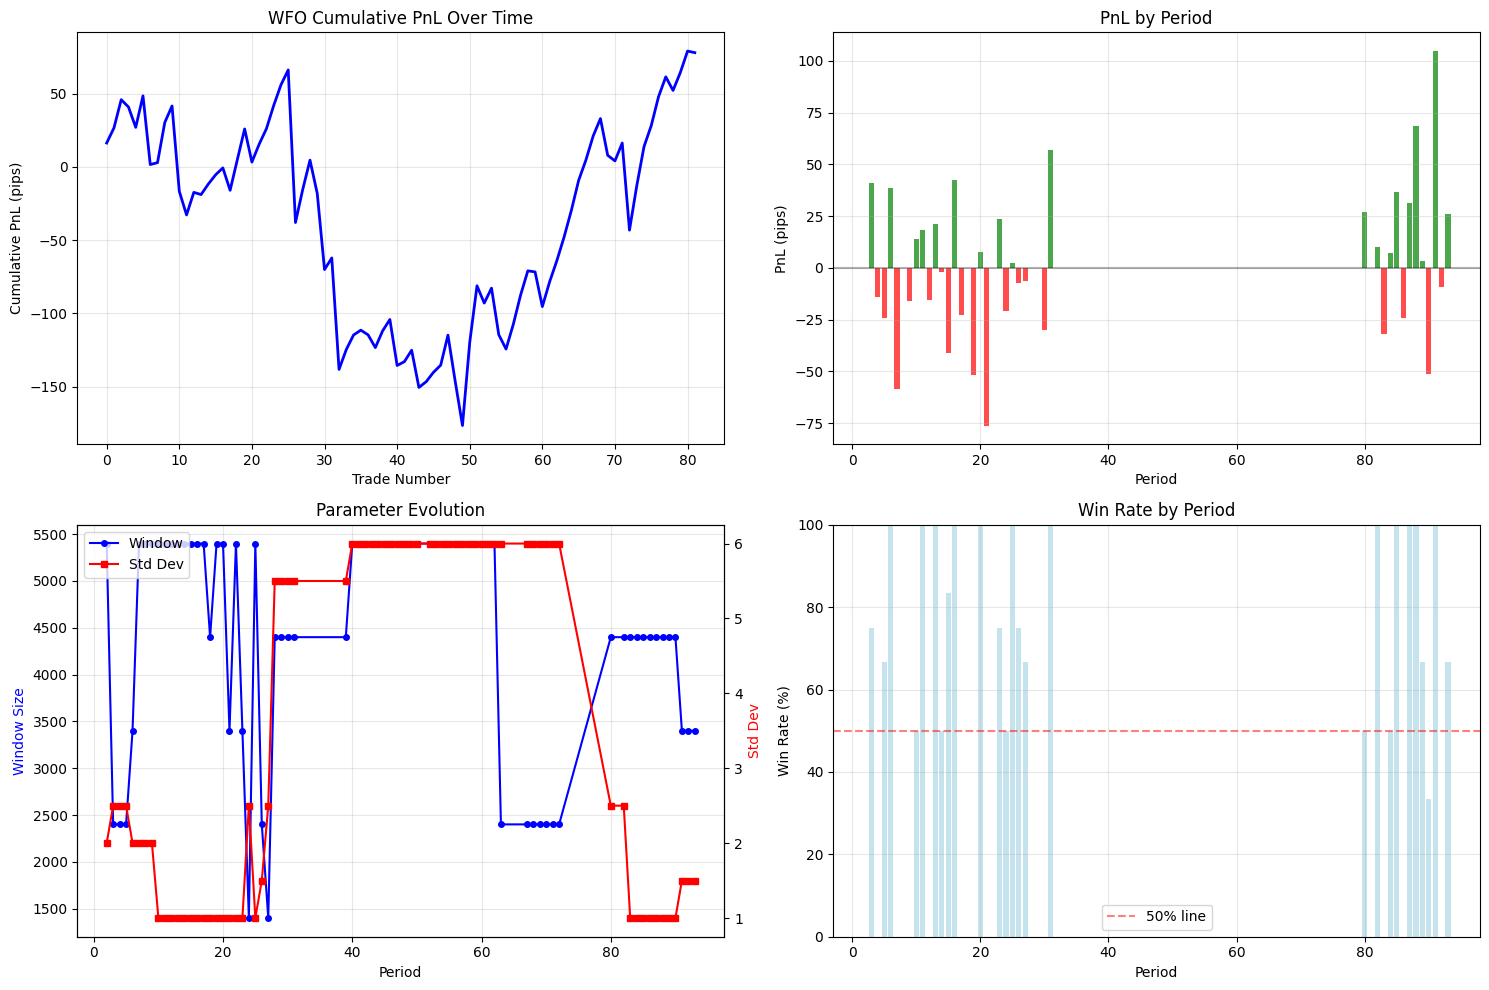


=== WALK FORWARD OPTIMIZATION SUMMARY ===
Total Periods: 93
Total PnL: 78.00 pips
Total Trades: 82
Winning Trades: 54
Losing Trades: 28
Win Rate: 65.85%
Max Drawdown: 242.80 pips
Average PnL per Period: 0.84 pips
Average PnL per Trade: 0.95 pips


In [16]:
# Force reload of the modules to ensure latest changes are loaded
import importlib
import sys

# Reload all backtester modules
modules_to_reload = [
    'modules.backtester.walk_forward',
    'modules.backtester.backtest_engine',
    'modules.backtester.indicators',
    'modules.backtester.data_loader',
    'modules.backtester.visualization',
    'modules.backtester.utils'
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        importlib.reload(sys.modules[module_name])

# Re-import the walk forward functions with the fixes
from modules.backtester.walk_forward import walk_forward_optimization, plot_wfo_results

# Execute Walk Forward Optimization with proper error handling
try:
    print("Starting Walk Forward Optimization...")
    wfo_results = walk_forward_optimization(
        minute_data=subset_df,
        lookback_days=180,  # Use 10 days of data for optimization
        optimization_interval_days=5,  # Re-optimize every 5 days
        window_start=400,
        window_stop=8000,
        window_step=1000,
        std_start=0.5,
        std_stop=6.0,
        std_step=0.5,
        price_column='midprice'
    )
    
    # Plot and analyze results
    plot_wfo_results(wfo_results)
    
except Exception as e:
    print(f"Error during Walk Forward Optimization: {e}")
    import traceback
    traceback.print_exc()
    print("Please check your data and parameters.")